In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import networkx as nx

# Topic: Vázquez link-copy model

Recall that the Barabasi-Albert preferential attachment model is used to create graphs with wide, or fat-tailed, degree distributions. This is desirable since we observe this scale-free behavior in many real world graphs, *e.g.* social networks. One feature that the BA model lacks when comparing to real social networks is node clustering. Real-world networks tend to have many triangles, and thus a higher average clustering coefficient, than random graphs.

In the lectures (go back to the slides on network models, I believe VI) we discussed extensions to the BA model that help capture additional network features. For this part of the exam, you are going to implement one of these extensions: the Vázquez link-copy model.

The algorithm has three parameters:

* *N*: the number of nodes in the resulting graph;
* *m*: the number of links added at each step;
* *p*: the probability of copying a link from a neighbor.

And the steps are as follows:

1. Start with a clique of *m* nodes.
2. At each step a new node *i* is added to the system, and sets *m* (>1) links as follows:
    1. The first new link targets a randomly chosen node *j* (distinct from *i*).
    2. From the second link onwards:
        1. With probability $p$ the new link target is a randomly-chosen neighbor of *j* (*i* copies a link from *j*);
        2. With probability $1-p$, the link target is a randomly-chosen node.
3. Repeat step 2 until you have *N* total nodes in the graph.

A caveat: you probably want to choose *j* and the link targets *before* adding nodes and links in order to avoid self-loops.

## Exercise 1

Complete the function below to create a graph using the link-copy model. You might find it helpful to go back and look at the tutorials in which we implemented other network models; this is similar to the BA model.

Notes:
* Make sure that the resulting graph has exactly *N* edges.
* As a simple check, `link_copy_graph(200, 4, 0.9)` should give you a graph with around 700 edges. 

In [2]:
def link_copy_graph(N, m, p):
    if not (1 <= m < N):
        raise nx.NetworkXError('m must satisfy ``1 <= m < n``')
        
    G = nx.complete_graph(m)
    
    for i in range(m, N):
        
        neighbors = set()
        
        j = random.choice(G.nodes())
        
        while len(neighbors) < m-1:
            
            probability_roll = random.random()
        
            if probability_roll < p:
                target = random.choice(G.neighbors(j))
                neighbors.add(target)
            else:
                target = random.choice([node for node in G.nodes() if node not in neighbors])
                neighbors.add(target)
        
        G.add_node(i)
        G.add_edge(i, j)
        for neighbor in neighbors:
            G.add_edge(i, neighbor)   
        
    return G

## Exercise 1x (2pt extra credit for correct answer)
Note that we execute the loop in the above algorithm a fixed (*i.e.* non-random) number of times. Generate a few graphs using the parameters `(200, 4, 0.9)` and observe that the number of edges fluctuates. Where do these fluctuations come from?

In [3]:
G = link_copy_graph(200, 4, 0.9)

print (len(G))
print (len(G.edges()))

#The fluctuations come from j sometimes being the same value twice. 
#When this occurs, an existing edge is replicated and thus not added.

200
790


## Exercise 2

The *raison d'être* for the Vasquez model is that it supposedly results in higher clustering coefficients. Explore the relationship between the *p* parameter and the average clustering coefficient by creating several graphs with varying *p* and plotting the resulting average clustering coefficients.

* Use $N=200$ and $m=4$ for each generated graph.
* The x-axis should be *p* and the y-axis the graph's average clustering coefficient.
* You should have at least 11 plot points covering the domain of *p*, *e.g.* [0.0, 0.1, ..., 0.9, 1.0]
  * you might consider using [numpy.linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) for this

<Container object of 11 artists>

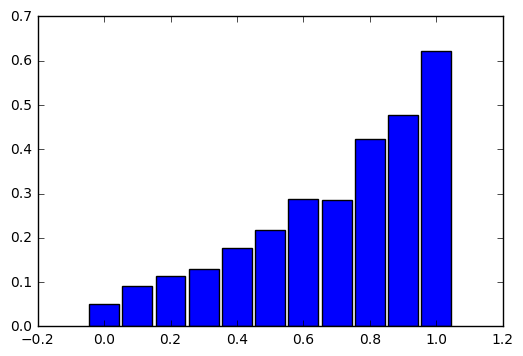

In [4]:
graphs = []

plot_points = np.linspace(0, 1, 11)

avg_cc = []

for i in plot_points:
    graphs.append(link_copy_graph(200, 4, i))
    
for graph in graphs:
    avg_cc.append(nx.average_clustering(graph))
    
plt.bar(list(plot_points), avg_cc, width=.09, align='center')

## Exercise 3

We introduced this model as an extension to Barabasi-Alberts, but it may not be obvious *a priori* that this model produces a graph with a fat-tailed degree distribution. Show using statistics and/or histograms that $p=0$ results in a narrow-tailed degree distribution, $p=1$ results in a fat tail, and $p=0.5$ is somewhere in between.

Again, you probably want to look back at your tutorials.

In [5]:
def degree_histogram(G, plot_type='bar', **kwargs):
    degree_count = Counter(G.degree().values())
    degrees = list(degree_count.keys())
    counts = list(degree_count.values())
    
    if plot_type == 'bar':
        plt.bar(degrees, counts, align='center', **kwargs)
    else:
        plt.scatter(degrees, counts, **kwargs)

[]

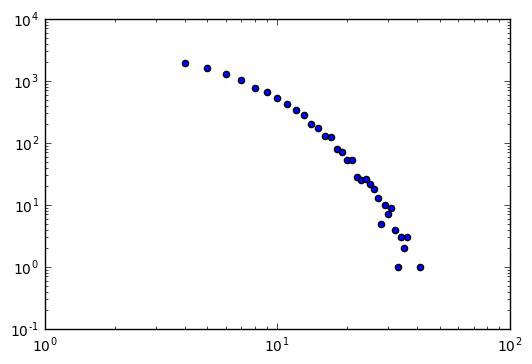

In [6]:
#narrow tail

G_0p = link_copy_graph(10000, 4, 0)
degree_histogram(G_0p, "scatter")
plt.loglog()

[]

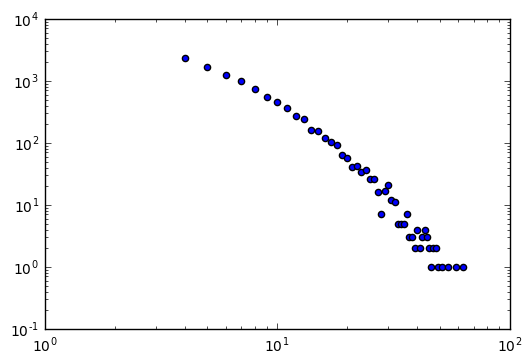

In [7]:
#somewhere in between

G_05p = link_copy_graph(10000, 4, 0.5)
degree_histogram(G_05p, "scatter")
plt.loglog()

[]

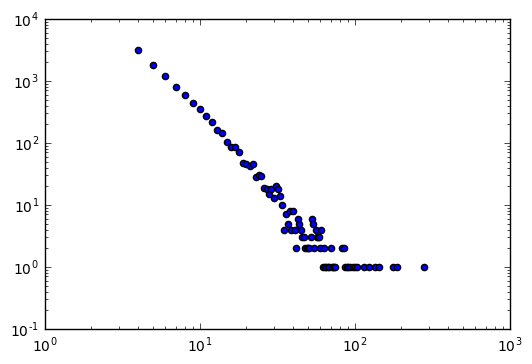

In [8]:
#fat tail

G_1p = link_copy_graph(10000, 4, 1)
degree_histogram(G_1p, "scatter")
plt.loglog()

# Topic: Comparing network partitions

The [variation of information][1] (VI) is a measure of similarity between two partitions $P_1$ and $P_2$ of the same network into communities. It computes how much information one must add to partition $P_1$ to recover partition $P_2$. So, if the partitions are identical, the VI is zero; if they differ the VI is different from zero, and VI can be large if the partitions are very different. Here we ask you to write the formula for the VI as seen in the [Wikipedia page][1].

[1]: https://en.wikipedia.org/wiki/Variation_of_information

Suppose there are $n$ nodes in the graph, and that partition $P_1$ has $n_1$ communities, and $P_2$ has $n_2$ communities. You need to compute two vectors (or lists) and one 2-dimensional array (or matrix, or list-of-lists). Vector ${\bf p}$ has $n_1$ entries: entry $p_i$ (the *i*-th item) is the fraction of nodes of community $i$ in partition $P_1$. That is, you need to divide the number of nodes of community $i$ in partition $P_1$ by $n$ and loop over all communities of the partition. Similarly, vector ${\bf q}$ has $n_2$ entries: entry $q_i$ is the fraction of nodes of community $i$ in partition $P_2$. 

The array ${\bf R}$ measures the relative overlap of communities of the two partitions. The element $R_{ij}$ (the item at row *i*, column *j*) is the proportion of nodes in common between community $i$ in partition $P_1$ and community $j$ in partition $P_2$, *i.e.* the number of nodes in common divided by $n$.

Once you have computed ${\bf p}$, ${\bf q}$ and ${\bf R}$ you can compute the VI from the function below:

In [9]:
#By Clayton Davis
import numpy as np

# This uses notation from the Wikipedia page
def variation_of_information(p_vec, q_vec, R_arr):
    running_sum = 0
    for i, p_i in enumerate(p_vec):
        for j, q_i in enumerate(q_vec):
            r_ij = R_arr[i][j]
            if r_ij > 0:
                log_sum = np.log(r_ij / p_i) + np.log(r_ij / q_i)
                running_sum += R_arr[i][j] * log_sum
    return -running_sum

## Exercise 4

Below are two partitions of the famous Karate Club graph generated by Louvain and Girvan-Newman clustering, respectively. Create ${\bf p}$, ${\bf q}$ and ${\bf R}$ given these two partitions, and compute the variation of information. If you did it right, you should get a value of $0.46$

Hints:
* You may want to look back at tutorial 2 on Schelling's model for how to create and work with `numpy` arrays/matrices.
* If you accidentally change P_1 and P_2 you won't get the right value for VI. It's probably best to work in a different notebook cell.

In [10]:
P_1 = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1,
    6: 1,
    7: 0,
    8: 2,
    9: 0,
    10: 1,
    11: 0,
    12: 0,
    13: 0,
    14: 2,
    15: 2,
    16: 1,
    17: 0,
    18: 2,
    19: 0,
    20: 2,
    21: 0,
    22: 2,
    23: 3,
    24: 3,
    25: 3,
    26: 2,
    27: 3,
    28: 3,
    29: 2,
    30: 2,
    31: 3,
    32: 2,
    33: 2,
}

P_2 = {
    0: 0,
    1: 0,
    2: 1,
    3: 0,
    4: 2,
    5: 2,
    6: 2,
    7: 0,
    8: 3,
    9: 4,
    10: 2,
    11: 0,
    12: 0,
    13: 0,
    14: 3,
    15: 3,
    16: 2,
    17: 0,
    18: 3,
    19: 0,
    20: 3,
    21: 0,
    22: 3,
    23: 3,
    24: 1,
    25: 1,
    26: 3,
    27: 1,
    28: 1,
    29: 3,
    30: 3,
    31: 1,
    32: 3,
    33: 3,
}


In [11]:
P_1_counts = Counter(P_1.values())
P_2_counts = Counter(P_2.values())

p = []
q = []
for item in P_1_counts:
    value = P_1_counts[item]/34
    p.append(value)
    
for item in P_2_counts:
    value = P_2_counts[item]/34
    q.append(value)

print(P_1_counts)
print(P_2_counts)
print (p)
print (q)

Counter({0: 12, 2: 11, 3: 6, 1: 5})
Counter({3: 12, 0: 10, 1: 6, 2: 5, 4: 1})
[0.35294117647058826, 0.14705882352941177, 0.3235294117647059, 0.17647058823529413]
[0.29411764705882354, 0.17647058823529413, 0.14705882352941177, 0.35294117647058826, 0.029411764705882353]


In [12]:
P1_community_lists = []
P1list0 = []
P1list1 = []
P1list2 = []
P1list3 = []

P2_community_lists = []
P2list0 = []
P2list1 = []
P2list2 = []
P2list3 = []
P2list4 = []

for key, value in P_1.items():
        if value == 0:
            P1list0.append(key)
        if value == 1:
            P1list1.append(key)
        if value == 2:
            P1list2.append(key)
        if value == 3:
            P1list3.append(key)

for key, value in P_2.items():
        if value == 0:
            P2list0.append(key)
        if value == 1:
            P2list1.append(key)
        if value == 2:
            P2list2.append(key)
        if value == 3:
            P2list3.append(key)
        if value == 4:
            P2list4.append(key)
            
P1_community_lists.append(P1list0)
P1_community_lists.append(P1list1)
P1_community_lists.append(P1list2)
P1_community_lists.append(P1list3)

P2_community_lists.append(P2list0)
P2_community_lists.append(P2list1)
P2_community_lists.append(P2list2)
P2_community_lists.append(P2list3)
P2_community_lists.append(P2list4)

Z = np.random.randint(0, 1, size=(4,5))

R = []

num_rows, num_cols = Z.shape

for i in range(num_rows):
    i_row = []
    for j in range(num_cols):
        var = (len(set(P1_community_lists[i]).intersection(set(P2_community_lists[j]))))
        i_row.append(float(var)/34)
    R.append(i_row)
    
R






[[0.29411764705882354, 0.029411764705882353, 0.0, 0.0, 0.029411764705882353],
 [0.0, 0.0, 0.14705882352941177, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.3235294117647059, 0.0],
 [0.0, 0.14705882352941177, 0.0, 0.029411764705882353, 0.0]]

In [13]:
variation_of_information(p, q, R)

0.46005279913485686